# Imports

In [1]:
import networkx as nx
import numpy as np
import math
from matplotlib import lines
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import Transformer
import random
import shapefile
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import subprocess
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

# Functions

## Data Loading

In [2]:
## This function is to load a .csv file into a pandas dataframe of desired format
def load_dataset(dataset_path, log_transform=False, bias=1e-2):
    print("...Loading Dataset...")
    raw_dataset = pd.read_csv(dataset_path)

    ## To add LOC_ID column
    loc_id = pd.Series([i for i in range(raw_dataset.shape[0])], name='LOC_ID')
    raw_dataset = pd.concat([loc_id.reset_index(drop=True), raw_dataset.reset_index(drop=True)], axis=1)

    ## If the data is to be bias + log_transformed
    if (log_transform == True):
        bias = 1e-2
        meta_columns = ['LOC_ID', 'LATITUDE', 'LONGITUDE', 'VALID_POINTS']
        dataset = raw_dataset.copy()
        dataset.loc[:, ~dataset.columns.isin(meta_columns)] = np.log1p(raw_dataset.loc[:, ~dataset.columns.isin(meta_columns)] + bias)
    else:
        dataset = raw_dataset

    return dataset

## Graph Generation

### Year-wise Dictionary

In [3]:
## This function is to generate year-wise daily rainfall for every location in a dictionary format
def make_year_wise_dict(dataframe, years=list(range(2015, 2023))):
    print("...Making year wise dictionary...")
    year_wise_dict = dict()

    year_columns = {
        year: [col for col in dataframe.columns if str(year) in str(col)]
        for year in years
    }
    
    col_positions = {col: i for i, col in enumerate(dataframe.columns)}

    def is_leap_year(year):
        return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

    ## itertuples is faster than iterrows, but it cannot alter the accessed data
    for row in dataframe.itertuples(index=False):
        loc_id = row.LOC_ID

        year_wise_dict[loc_id] = {}

        for year in years:
            cols = year_columns[year]

            if is_leap_year(year):
                cols = [col for col in cols if not "02-29" in str(col)]

            rainfall_vector = [row[col_positions[col]] for col in cols]
            year_wise_dict[loc_id][year] = np.array(rainfall_vector)

    return year_wise_dict

### Cosine Similarity Dictionary

In [4]:
## This function to compute cosine similarity matrix for every location
def make_cos_sim_dict(year_wise_dict, ids, years=list(range(2015, 2023))):
    print("...Making cosine similarity dictionary...")
    cos_sim_dict = dict()

    for id in ids:

        vectors = [year_wise_dict[id][year] for year in years]
        tensor_data = torch.tensor(vectors, dtype=torch.float32)

        norm_data = torch.nn.functional.normalize(tensor_data, p=2, dim=1)
        sim_matrix = torch.mm(norm_data, norm_data.T)

        ## To write the similarity as 1 - cosine similarity
        sim_matrix = 1 - sim_matrix
        
        cos_sim_dict[id] = sim_matrix

    return cos_sim_dict

### Mean Node Generation

In [48]:
## This function is to make a mean node for all locations
def make_mean_node(year_wise_dict, ids, years=list(range(2015, 2023))):
    print("...Making mean nodes...")    
    for id in ids:
        sum = np.zeros(np.shape(year_wise_dict[id][2022]))

        for year in years:
            sum += year_wise_dict[id][year]

        year_wise_dict[id]['MEAN'] = sum / len(years)

    return year_wise_dict

### Generating the Threshold

In [49]:
## This function is to make a dictionary of percentile based threshold values for the similarity score
def make_threshold_dict(cos_sim_dict, train_ids):
    print("...Making threshold dictionary...")
    all_cos_sims = []

    for train_id in train_ids:
        cos_sim = cos_sim_dict[train_id]
        cos_sim_no_diag = cos_sim.clone()
        cos_sim_no_diag.fill_diagonal_(float('nan'))

        flat_sims = cos_sim_no_diag[~torch.isnan(cos_sim_no_diag)]
        all_cos_sims.append(flat_sims)

    ## This is the tensor that has all the cosine-similarity scores (exclusing self-similarites) for all TRGCODEs and YEARs
    all_cos_sims = torch.cat(all_cos_sims)

    global_percentile_dict = {}

    for i in range(5, 100, 5):
        global_percentile_dict[i] = torch.quantile(all_cos_sims, i/100).item()

    return global_percentile_dict

### Label Generating

In [50]:
## This function is to generate labels for the locations
def generate_labels(cos_sim_dict, threshold, ids):
    print("...Generating Labels...")
    stable_rain = set()
    unstable_rain = set()

    for id in ids: ## Labels for all graphs are generated using threshold computed on training set
        sim_matrix = cos_sim_dict[id]
        loc_mean = (sim_matrix.sum() - sim_matrix.trace()) / (64 - 8)

        if (loc_mean <= threshold):
            stable_rain.add(id)
        else:
            unstable_rain.add(id)

    return stable_rain, unstable_rain

### Making Graphs

In [51]:
## This function is to make the actual graphs
def make_graphs(year_wise_dict, cos_sim_dict, ids, threshold, years=list(range(2015, 2023))):
    print("...Making Graphs...")
    graphs = dict()

    stable_rain, unstable_rain = generate_labels(
        cos_sim_dict=cos_sim_dict,
        threshold=threshold,
        ids=ids
    )

    for id in ids:

        edge_list = []

        for i in range(len(years)):
            
            ## 0 is considered as the average node, and each year node has the index (year - 2014)
            edge_list.append([[i + 1], [0]])

            for j in range(len(years)):
                if i < j:
                    score = cos_sim_dict[id][i][j]

                    if score <= threshold:
                        ## Each year node has the index (year - 2014)
                        edge_list.append([[i + 1], [j + 1]])

        edge_list = np.hstack(edge_list)
        edge_list = torch.tensor(edge_list, dtype=torch.long)
        
        node_features = [year_wise_dict[id]['MEAN']]

        for year in years:
            node_features.append(year_wise_dict[id][year])

        node_features = np.vstack(node_features)
        node_features = torch.tensor(node_features, dtype=torch.float)

        if (id in stable_rain):
            label = torch.tensor([1])
        else: 
            label = torch.tensor([0])

        graph = Data(x=node_features, edge_index=edge_list, y=label)

        graphs[id] = graph

    return graphs

### Final Function

In [52]:
## This function is to generate graphs given a dataframe
def generate_graphs(dataframe, train=False, threshold_percentile=25, threshold_value=None):
    print(f"...Generating graphs: training_mode: {train}, threshold_percentile: {threshold_percentile}...")

    ## The unique IDs for each location
    loc_ids = dataframe['LOC_ID'].values

    ## The various years in the dataset
    years = pd.to_datetime(dataframe.columns[4:]).year
    years = sorted(years.unique())

    ## Obtain year-wise daily rainfall for every location in a dictionary format
    year_wise_dict = make_year_wise_dict(
        dataframe=dataframe,
        years=years
    )

    ## Compute cosine similarity matrix for every location
    cos_sim_dict = make_cos_sim_dict(
        year_wise_dict=year_wise_dict,
        ids=loc_ids,
        years=years
    )

    ## To make a mean node for all locations
    year_wise_dict = make_mean_node(
        year_wise_dict=year_wise_dict,
        ids=loc_ids,
        years=years
    )

    if (train == True): ## For generating thresholds during training
        ## Splitting the data into training and validating sets
        train_loc_ids, validate_loc_ids = train_test_split(
            loc_ids,
            test_size=0.2,
            random_state=3707
        )

        ## Generating the various thresholds to select for training
        global_percentile_dict = make_threshold_dict(
            cos_sim_dict=cos_sim_dict,
            train_ids=train_loc_ids
        )
        
        ## Defining the threshold
        threshold_value = global_percentile_dict[threshold_percentile]

        ## Threshold to return
        return_threshold = threshold_value

    ## Making the actual graphs
    graphs = make_graphs(
        year_wise_dict=year_wise_dict,
        cos_sim_dict=cos_sim_dict,
        ids=loc_ids,
        years=years,
        threshold=threshold_value
    )

    if (train  == True):
        ## Converting the ids to sets for faster lookups
        train_loc_ids = set(train_loc_ids)
        validate_loc_ids = set(validate_loc_ids)

        ## Initializing the graph dictionaries
        train_graphs = dict()
        validation_graphs = dict()

        ## Assignign the graphs to the correct dictionary
        for loc_id, graph in graphs.items():
            if loc_id in train_loc_ids:
                train_graphs[loc_id] = graph
            else:
                validation_graphs[loc_id] = graph

        return train_graphs, validation_graphs, graphs, return_threshold
    else:
        return graphs

## Model

### Class Weighting

In [53]:
## This function is to compute class weights given a set of graphs
def find_class_weights(train_graphs):
    print("...Computing Class Weights...")
    ## To get a list of class labels, later used for class balancing
    stratify_labels = [graph.y.item() for graph in train_graphs.values()]

    ## Computing class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=[0, 1],
        y=[graph.y.item() for graph in train_graphs.values()]
    )

    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    return class_weights_tensor

### Training

#### Pass Forward Training

In [54]:
## This function is to perform one forward pass while training
def training_pass(train_loader, model, criterion, optimizer):
    model.train() ## Toggles training mode. Enables dropout, updates running statistics, etc. READ MORE.

    total_loss = 0

    for train_graph in train_loader:
        out = model(train_graph.x.float(), train_graph.edge_index, train_graph.batch) ## A single forward pass
        loss = criterion(out, train_graph.y.long()) ## Compute cross entropy loss
        loss.backward() ## Find the gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step() ## Update parameters based on gradients
        optimizer.zero_grad() ## Clear gradients
        total_loss += loss.item() * train_graph.num_graphs
    
    return total_loss / len(train_loader.dataset)

#### Evaluating Pass

In [55]:
## This function is to evaluate the results of a forward pass
def evaluate_pass(data_loader, model):
    model.eval() ## Toggles testing behaviour. READ MORE.

    correct = 0

    for graph in data_loader:
        out = model(graph.x.float(), graph.edge_index, graph.batch)
        prediction = out.argmax(dim=1) ## Use the class with highest probability
        correct += int((prediction == graph.y).sum())
    
    return correct / len(data_loader.dataset)

#### Final Function

In [56]:
## This function is to train the model
def train_model(train_dataframe, model, threshold_percentile=25):
    print("...Training Model...")
    
    ## Generating graphs from the training dataframe
    train_graphs, validation_graphs, graphs, threshold_value = generate_graphs(
        dataframe=train_dataframe,
        train=True,
        threshold_percentile=threshold_percentile
    )

    ## Setting up loaders for both sets
    train_loader = DataLoader(
        dataset=list(train_graphs.values()),
        batch_size=128,
        shuffle=True
    )
    validation_loader = DataLoader(
        dataset=list(validation_graphs.values()),
        batch_size=32,
        shuffle=True
    )

    ## Computing class weights
    class_weights_tensor = find_class_weights(train_graphs=train_graphs)

    ## Initializing the training optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=5,
        verbose=True
    )

    ## Defining the evaluation criterion
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor) 

    ## Variables to store training loop variables
    losses = list()
    train_accuracies = list()
    validate_accuracies = list()

    best_test_accuracy = 0
    patience_counter = 0
    patience = 10

    ## Main training loop
    for epoch in range(1, 120):
        loss = training_pass(
            train_loader=train_loader,
            model=model,
            criterion=criterion,
            optimizer=optimizer
        )
        losses.append(loss)
        train_accuracy = evaluate_pass(
            data_loader=train_loader,
            model=model
        )
        validate_accuracy = evaluate_pass(
            data_loader=validation_loader,
            model=model
        )
        train_accuracies.append(train_accuracy)
        validate_accuracies.append(validate_accuracy)
        print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.4f}, Validate Accuracy: {validate_accuracy:.4f}, Patience Counter: {patience_counter}')

        scheduler.step(validate_accuracy)

        if (validate_accuracy > best_test_accuracy):
            best_test_accuracy = validate_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1

        if patience_counter > patience:
            print("----- Early stopping triggered -----")
            break

    ## Saving the model
    torch.save(model.state_dict(), 'Model_1_minus_cos.pth')

    ## Plotting the results of training
    plot_loss_curves(# type: ignore
        losses=losses,
        train_accuracies=train_accuracies,
        validate_accuracies=validate_accuracies
    )

    ## Plotting the t-SNE plot
    plot_tsne(# type: ignore
        model=model,
        graphs=graphs
    )

    return train_graphs, validation_graphs, graphs, threshold_value

### Predictions

In [57]:
## This function is to make predictions
def make_predictions(model, graphs):
    print("...Making predictions...")
    model.eval()

    y_pred = dict()

    for id, graph in graphs.items():

        with torch.no_grad():
            num_nodes = graph.x.size(0)
            batch = torch.zeros(num_nodes, dtype=torch.long)
            out = model(graph.x.float(), graph.edge_index, batch)
            prediction = out.argmax(dim=1).item()

        y_pred[id] = prediction

    return y_pred

### Truths

In [58]:
## This function is to get the true labels for graphs
def get_true_labels(model, graphs):
    print("...Getting true labels...")

    y_true = dict()

    for id, graph in graphs.items():
        y_true[id] = graph.y.item()

    return y_true

## Visualizations

### Graphs

In [59]:
## This function is to visualize graphs
def display_graph(graphs, num_graphs=1):
    print(f"...Plotting {num_graphs} graphs...")
    
    for i in range(num_graphs):
        rand_id = np.random.choice(list(graphs.keys()))
        print(f"The randomly selected TRGCODE is {rand_id}")

        G = to_networkx(graphs[rand_id], to_undirected=True)

        fig, ax = plt.subplots(figsize=(6, 4))
        nx.draw(G, ax=ax, with_labels=True, node_size=300, node_color='skyblue')
        plt.show()

### Plotting Loss Curves

In [60]:
## This function is to plot the loss curves
def plot_loss_curves(losses, train_accuracies, validate_accuracies):
    print("...Plotting loss curves...")
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(20, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'b-')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'g--', label='Training Accuracy')
    plt.plot(epochs, validate_accuracies, 'r--', label='Validating Accuracy')
    plt.legend()
    plt.ylim(0.5, 1)
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return

### Plotting t-SNE

In [61]:
## This function is to plot the t-SNE curve
def plot_tsne(model, graphs):
    print("...Plotting t-SNE...")
    
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for graph in graphs.values():
            x = graph.x.float()
            edge_index = graph.edge_index
            batch = torch.zeros(x.size(0), dtype=torch.long)
            out = model.conv1(x, edge_index)
            out = out.relu()
            out = model.conv2(out, edge_index)
            graph_embed = global_max_pool(out, batch)
            
            embeddings.append(graph_embed.cpu().numpy())
            labels.append(graph.y.item())

    # Reduce to 2D
    embeddings_2d = TSNE(n_components=2).fit_transform(np.vstack(embeddings))

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.title("t-SNE of Graph Embeddings")
    plt.colorbar(label="Class (0=Unstable, 1=Stable)")
    plt.show()

    return

### Geographical Map

In [62]:
## This function is to visualize the stable and unstable regions in a geographical map
def display_geo_map(dataframe, y_pred, shapefile_path, ids, transform=False, figsize=(10, 10)):
    print("...Plotting geographical map...")
    # Initialize shapefile reader
    sf = shapefile.Reader(shapefile_path)

    if (transform == True):
        # UTM Zone 43N → WGS84 lat/lon
        transformer = lambda x, y: Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True).transform(x, y)
    else:
        ## Identity Transformation
        transformer = lambda x, y: (x, y)

    fig, ax = plt.subplots(figsize=figsize)

    for shape in sf.shapes():
        points = shape.points
        parts = list(shape.parts) + [len(points)]
        
        for i in range(len(parts) - 1):
            part_points = points[parts[i]:parts[i + 1]]
            x_proj, y_proj = zip(*part_points)
            lon, lat = transformer(x_proj, y_proj)
            ax.plot(lon, lat, color='black')

    for id in ids:

        if y_pred[id] == 1:
            color = 'red'
            alpha = 0.7
        else:
            color = 'green'
            alpha = 0.5

        plt.scatter(
            dataframe.loc[dataframe['LOC_ID'] == id, 'LONGITUDE'],
            dataframe.loc[dataframe['LOC_ID'] == id, 'LATITUDE'],
            color=color,
            alpha=alpha
        )

    legend_elements = [
        lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=8, alpha=0.7),
        lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=8, alpha=0.5)
    ]

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.title("Geographical Map Visualization")
    plt.legend(handles=legend_elements)
    plt.grid(True)
    plt.show()

# Loading the Model

## Defining the Model Architecture

In [63]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(3707)
        self.conv1 = GCNConv(365, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels) ## Same size to refine node embeddings
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        ## STEP 1: To obtain node embeddings
        x = self.conv1(x, edge_index) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)

        ## STEP 2: Readout layer
        x = global_max_pool(x, batch) ## Computes batch wise mean of the graphs that have been batched. Returns one feature vector per batch

        ## STEP 3: Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training) ## Dropout is regularization to prevent overfitting
        x = self.lin(x)

        return x

## Loading the Weights

In [64]:
model = GCN(hidden_channels=32)
# # model.load_state_dict(torch.load('model_log_bias.pth'))
# model.load_state_dict(torch.load('model_vanilla.pth'))

# Training

In [65]:
karnataka_dataset = load_dataset(
    dataset_path='karnataka_grid_timeseries.csv',
    bias=1e-2,
    log_transform=True
)

...Loading Dataset...


In [66]:
karnataka_dataset

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
0,0,74.05,11.55,70090,0.00995,0.260429,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.064802,0.00995,0.00995,0.00995
1,1,74.05,11.65,70090,0.00995,0.246313,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.056138,0.00995,0.00995,0.00995
2,2,74.05,11.75,70090,0.00995,0.271153,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
3,3,74.05,11.85,70090,0.00995,0.187557,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
4,4,74.05,11.95,70090,0.00995,0.009950,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,3332,78.65,18.15,70090,0.00995,0.289214,3.155521,1.580908,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
3333,3333,78.65,18.25,70090,0.00995,1.029152,3.221312,1.662487,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
3334,3334,78.65,18.35,70090,0.00995,1.381178,3.234633,1.688603,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
3335,3335,78.65,18.45,70090,0.00995,1.854065,3.238666,1.690454,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995


...Training Model...
...Generating graphs: training_mode: True, threshold_percentile: 25...
...Making year wise dictionary...
...Making cosine similarity dictionary...
...Making mean nodes...
...Making threshold dictionary...
...Making Graphs...
...Generating Labels...
...Computing Class Weights...


/home/prad/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 001, Train Accuracy: 0.9614, Validate Accuracy: 0.9716, Patience Counter: 0
Epoch: 002, Train Accuracy: 0.9918, Validate Accuracy: 0.9925, Patience Counter: 0
Epoch: 003, Train Accuracy: 0.9899, Validate Accuracy: 0.9910, Patience Counter: 0
Epoch: 004, Train Accuracy: 0.9813, Validate Accuracy: 0.9880, Patience Counter: 1
Epoch: 005, Train Accuracy: 0.9771, Validate Accuracy: 0.9850, Patience Counter: 2
Epoch: 006, Train Accuracy: 0.9869, Validate Accuracy: 0.9910, Patience Counter: 3
Epoch: 007, Train Accuracy: 0.9809, Validate Accuracy: 0.9865, Patience Counter: 4
Epoch: 008, Train Accuracy: 0.9876, Validate Accuracy: 0.9940, Patience Counter: 5
Epoch: 009, Train Accuracy: 0.9865, Validate Accuracy: 0.9880, Patience Counter: 0
Epoch: 010, Train Accuracy: 0.9880, Validate Accuracy: 0.9925, Patience Counter: 1
Epoch: 011, Train Accuracy: 0.9873, Validate Accuracy: 0.9925, Patience Counter: 2
Epoch: 012, Train Accuracy: 0.9914, Validate Accuracy: 0.9955, Patience Counter: 3
Epoc

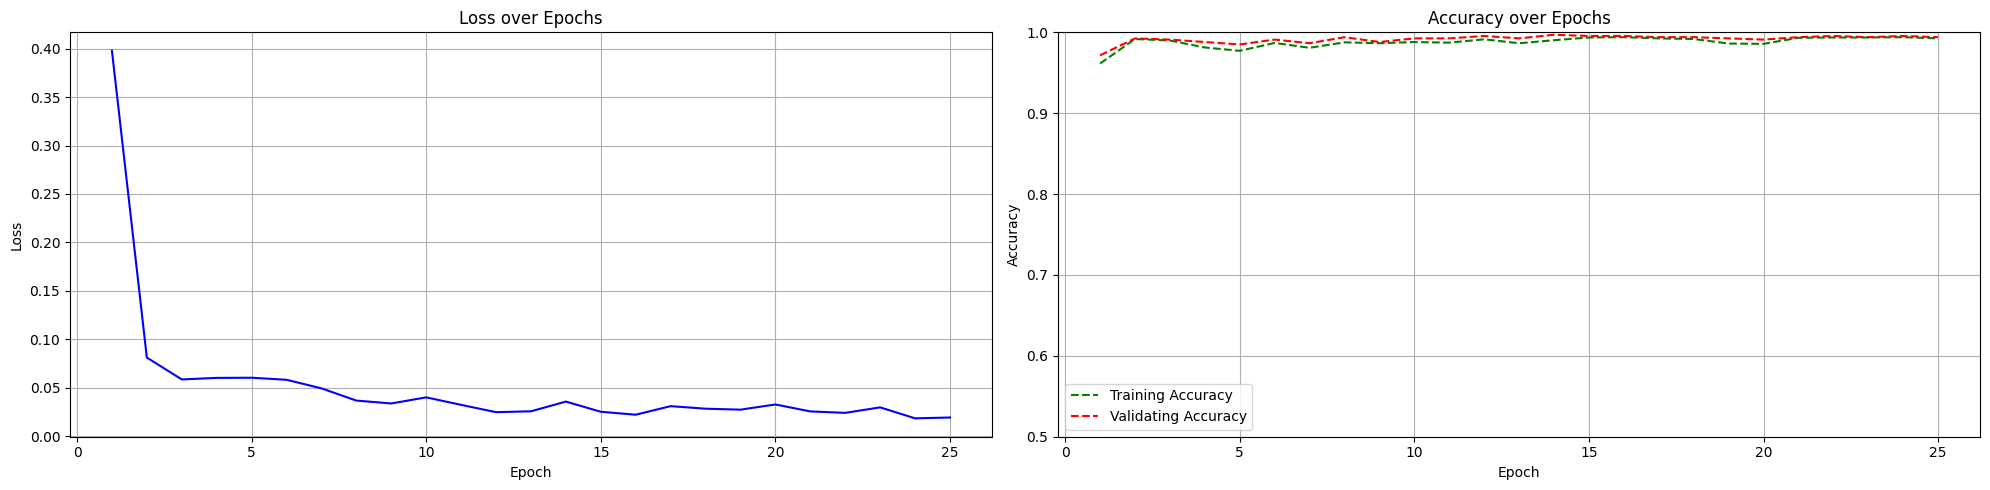

...Plotting t-SNE...


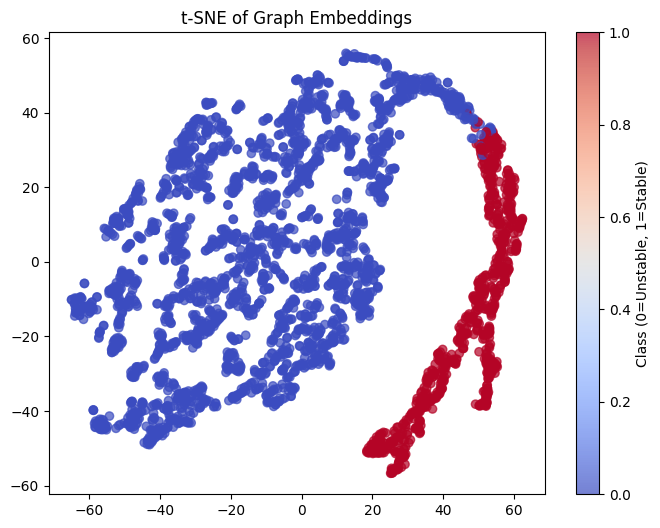

In [67]:
train_graphs, validation_graphs, graphs, threshold_value = train_model(
    train_dataframe=karnataka_dataset,
    model=model,
    threshold_percentile=25
)

In [68]:
y_pred_validate = make_predictions(
    model=model,
    graphs=validation_graphs
)

...Making predictions...


In [69]:
y_pred_all = make_predictions(
    model=model,
    graphs=graphs
)

...Making predictions...


In [70]:
y_pred = list()
y_true = list()

for id, graph in validation_graphs.items():
    y_pred.append(y_pred_validate[id])
    y_true.append(graph.y.item())

print(len(y_pred))
print(len(y_true))

668
668


In [71]:
print(y_true)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [72]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[515   3]
 [  1 149]]



Classification Report:
              precision    recall  f1-score   support

    Unstable       1.00      0.99      1.00       518
      Stable       0.98      0.99      0.99       150

    accuracy                           0.99       668
   macro avg       0.99      0.99      0.99       668
weighted avg       0.99      0.99      0.99       668



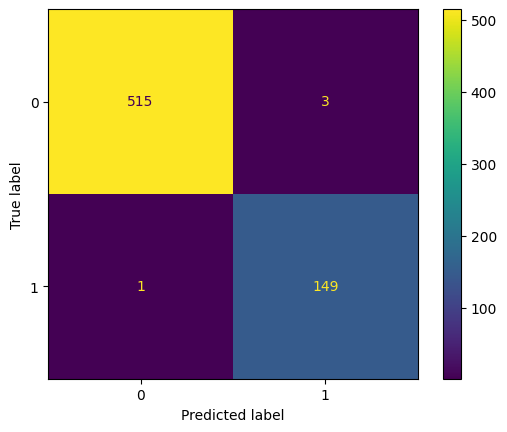

In [73]:
ConfusionMatrixDisplay(cm).plot()

print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=['Unstable', 'Stable']))

...Plotting geographical map...


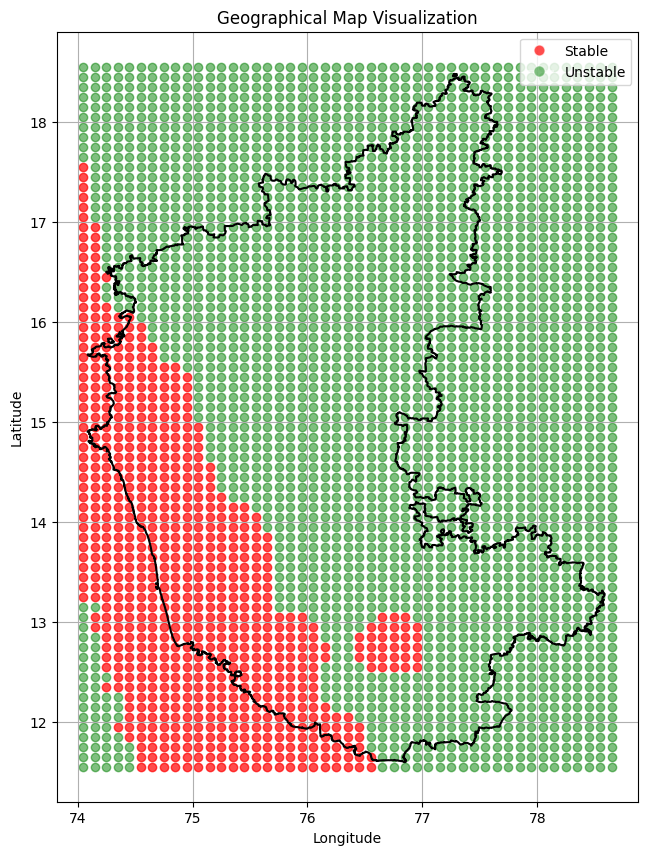

In [74]:
display_geo_map(
    dataframe=karnataka_dataset,
    y_pred=y_pred_all,
    shapefile_path='Karnataka/State.shp',
    ids=graphs.keys(),
    transform=True,
    figsize=(7.5, 10)
)

# Testing

## Karnataka

In [75]:
karnataka_dataset = load_dataset(
    dataset_path='karnataka_grid_timeseries.csv',
    bias=1e-2,
    log_transform=True
)

...Loading Dataset...


In [76]:
karnataka_dataset

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
0,0,74.05,11.55,70090,0.00995,0.260429,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.064802,0.00995,0.00995,0.00995
1,1,74.05,11.65,70090,0.00995,0.246313,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.056138,0.00995,0.00995,0.00995
2,2,74.05,11.75,70090,0.00995,0.271153,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
3,3,74.05,11.85,70090,0.00995,0.187557,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
4,4,74.05,11.95,70090,0.00995,0.009950,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332,3332,78.65,18.15,70090,0.00995,0.289214,3.155521,1.580908,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
3333,3333,78.65,18.25,70090,0.00995,1.029152,3.221312,1.662487,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
3334,3334,78.65,18.35,70090,0.00995,1.381178,3.234633,1.688603,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995
3335,3335,78.65,18.45,70090,0.00995,1.854065,3.238666,1.690454,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.009950,0.00995,0.00995,0.00995


In [36]:
year_wise_dict_ka = make_year_wise_dict(dataframe=karnataka_dataset)

In [134]:
karnataka_graphs = generate_graphs(
    dataframe=karnataka_dataset,
    train=False
)

In [135]:
karnataka_y_pred = make_predictions(
    model=model,
    graphs=karnataka_graphs
)

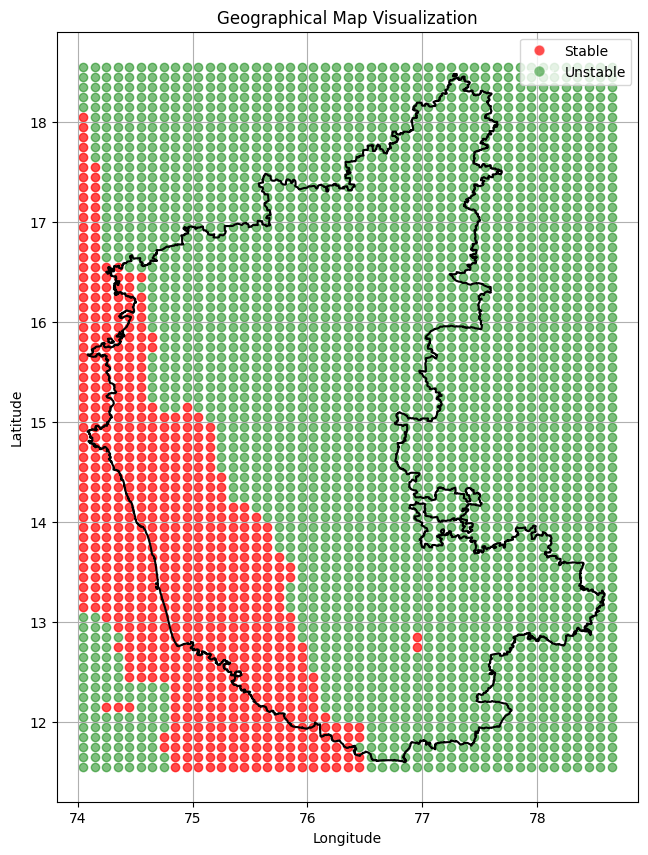

In [136]:
display_geo_map(
    dataframe=karnataka_dataset,
    y_pred=karnataka_y_pred,
    shapefile_path='Karnataka/State.shp',
    ids=karnataka_dataset['LOC_ID'].values,
    transform=True,
    figsize=(7.5, 10)
)

## Maharashtra

In [77]:
mh_dataset = load_dataset(
    dataset_path='maharashtra_grid_timeseries.csv',
    bias=1e-2,
    log_transform=True
)

...Loading Dataset...


In [78]:
mh_dataset

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
0,0,71.95,14.05,70090,0.009950,0.009950,0.009950,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
1,1,71.95,14.15,70090,0.009950,0.009950,0.009950,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
2,2,71.95,14.25,70090,0.009950,0.009950,0.009950,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
3,3,71.95,14.35,70090,0.009950,0.009950,0.009950,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
4,4,71.95,14.45,70090,0.009950,0.009950,0.009950,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9186,9186,81.95,22.65,70090,1.718022,0.706443,1.416139,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
9187,9187,81.95,22.75,70090,1.766489,0.736254,1.343419,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
9188,9188,81.95,22.85,70090,1.796657,0.732989,1.334412,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
9189,9189,81.95,22.95,70090,1.837231,0.721403,1.426811,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995


In [79]:
mh_graphs = generate_graphs(
    dataframe=mh_dataset,
    train=False,
    threshold_value=threshold_value
)

...Generating graphs: training_mode: False, threshold_percentile: 25...
...Making year wise dictionary...
...Making cosine similarity dictionary...
...Making mean nodes...
...Making Graphs...
...Generating Labels...


In [80]:
mh_y_pred = make_predictions(
    model=model,
    graphs=mh_graphs
)

...Making predictions...


...Plotting geographical map...


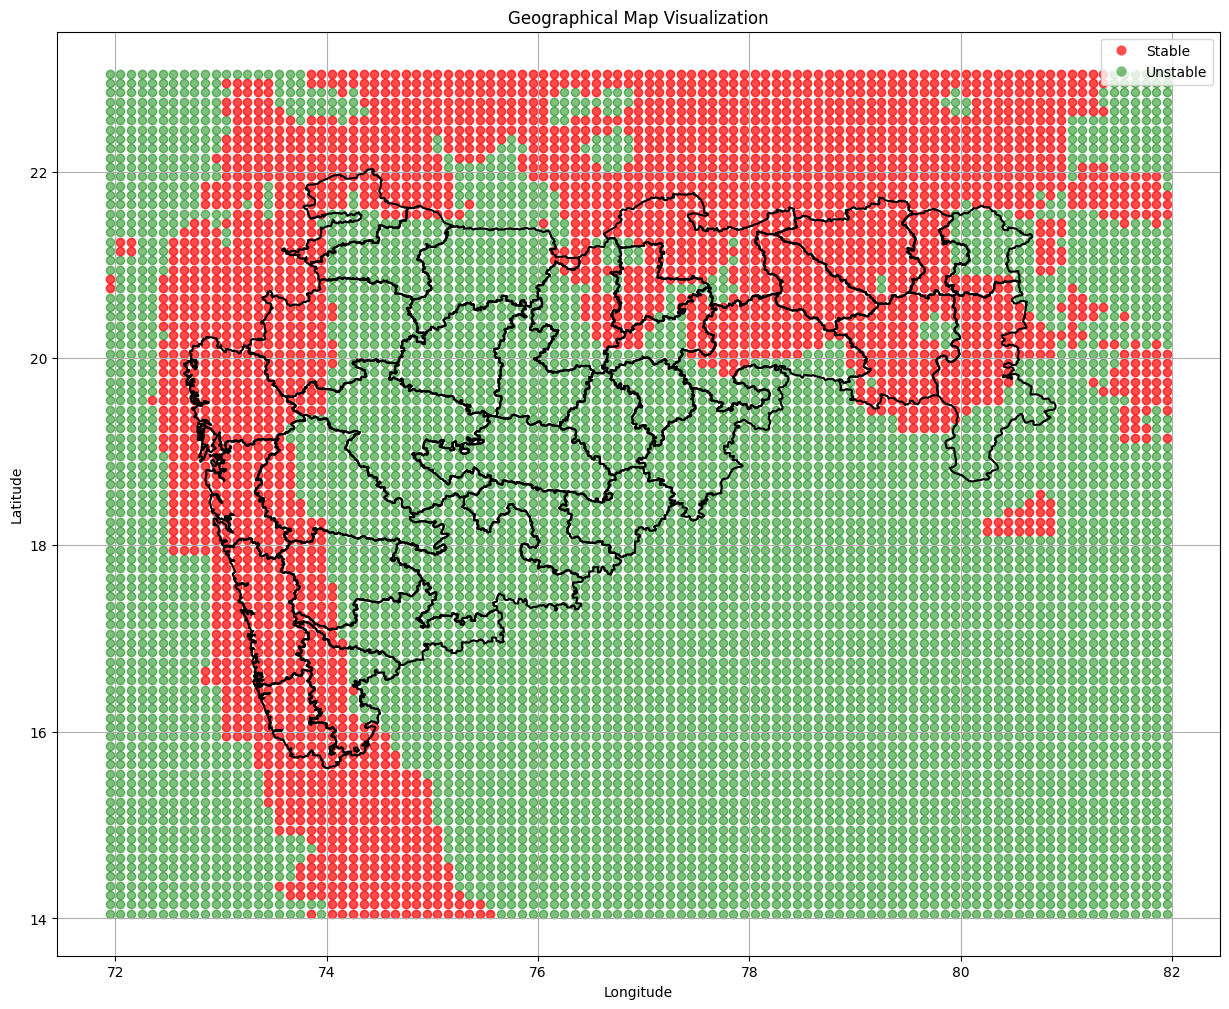

In [81]:
display_geo_map(
    dataframe=mh_dataset,
    y_pred=mh_y_pred,
    shapefile_path='new_maha_district.shp',
    ids=mh_dataset['LOC_ID'].values,
    transform=False,
    figsize=(15, 12)
)

In [82]:
mh_y_pred = make_predictions(
    model=model,
    graphs=mh_graphs
)

...Making predictions...


In [83]:
mh_y_true = get_true_labels(
    model=model,
    graphs=mh_graphs
)

...Getting true labels...


[[5471  981]
 [ 730 2009]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       0.88      0.85      0.86      6452
      Stable       0.67      0.73      0.70      2739

    accuracy                           0.81      9191
   macro avg       0.78      0.79      0.78      9191
weighted avg       0.82      0.81      0.82      9191



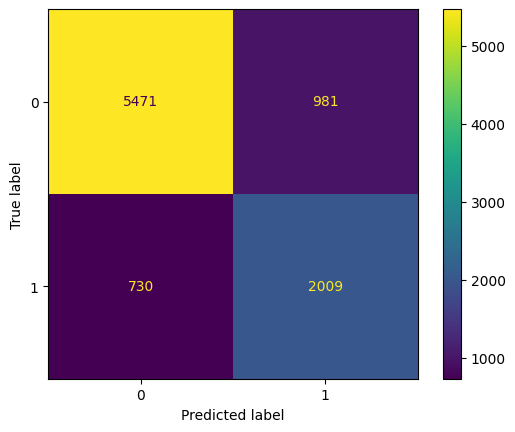

In [84]:
mh_cm = confusion_matrix(list(mh_y_true.values()), list(mh_y_pred.values()))
print(mh_cm)

ConfusionMatrixDisplay(mh_cm).plot()

print('\nClassification Report:')
print(classification_report(list(mh_y_true.values()), list(mh_y_pred.values()), target_names=['Unstable', 'Stable']))

## Central India

In [85]:
central_ind_dataset = load_dataset(
    dataset_path='central_india_grid_timeseries.csv',
    bias=1e-2,
    log_transform=True
)

...Loading Dataset...


In [86]:
central_ind_dataset

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
0,0,74.95,15.05,70090,0.009950,0.009950,0.009950,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
1,1,74.95,15.15,70090,0.009950,0.009950,0.009950,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
2,2,74.95,15.25,70090,0.009950,0.009950,0.009950,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
3,3,74.95,15.35,70090,0.009950,0.009950,0.009950,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
4,4,74.95,15.45,70090,0.009950,0.009950,0.009950,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196,10196,84.95,24.65,70090,1.551015,0.957640,0.942569,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
10197,10197,84.95,24.75,70090,1.657211,1.184335,0.928381,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
10198,10198,84.95,24.85,70090,1.664189,1.137962,0.773179,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
10199,10199,84.95,24.95,70090,1.608863,0.791641,0.694857,0.00995,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995


In [87]:
central_ind_graphs = generate_graphs(
    dataframe=central_ind_dataset,
    train=False,
    threshold_value=threshold_value
)

...Generating graphs: training_mode: False, threshold_percentile: 25...
...Making year wise dictionary...
...Making cosine similarity dictionary...
...Making mean nodes...
...Making Graphs...
...Generating Labels...


In [88]:
central_ind_y_pred = make_predictions(
    model=model,
    graphs=central_ind_graphs
)

...Making predictions...


In [89]:
central_ind_y_true = get_true_labels(
    model=model,
    graphs=central_ind_graphs
)

...Getting true labels...


[[4626 1822]
 [1636 2117]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       0.74      0.72      0.73      6448
      Stable       0.54      0.56      0.55      3753

    accuracy                           0.66     10201
   macro avg       0.64      0.64      0.64     10201
weighted avg       0.66      0.66      0.66     10201



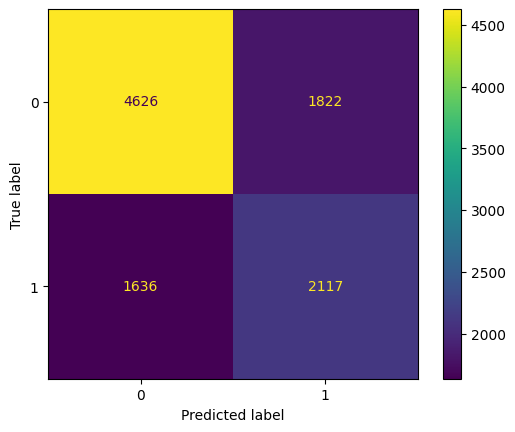

In [90]:
central_ind_cm = confusion_matrix(list(central_ind_y_true.values()), list(central_ind_y_pred.values()))
print(central_ind_cm)

ConfusionMatrixDisplay(central_ind_cm).plot()

print('\nClassification Report:')
print(classification_report(list(central_ind_y_true.values()), list(central_ind_y_pred.values()), target_names=['Unstable', 'Stable']))

...Plotting geographical map...


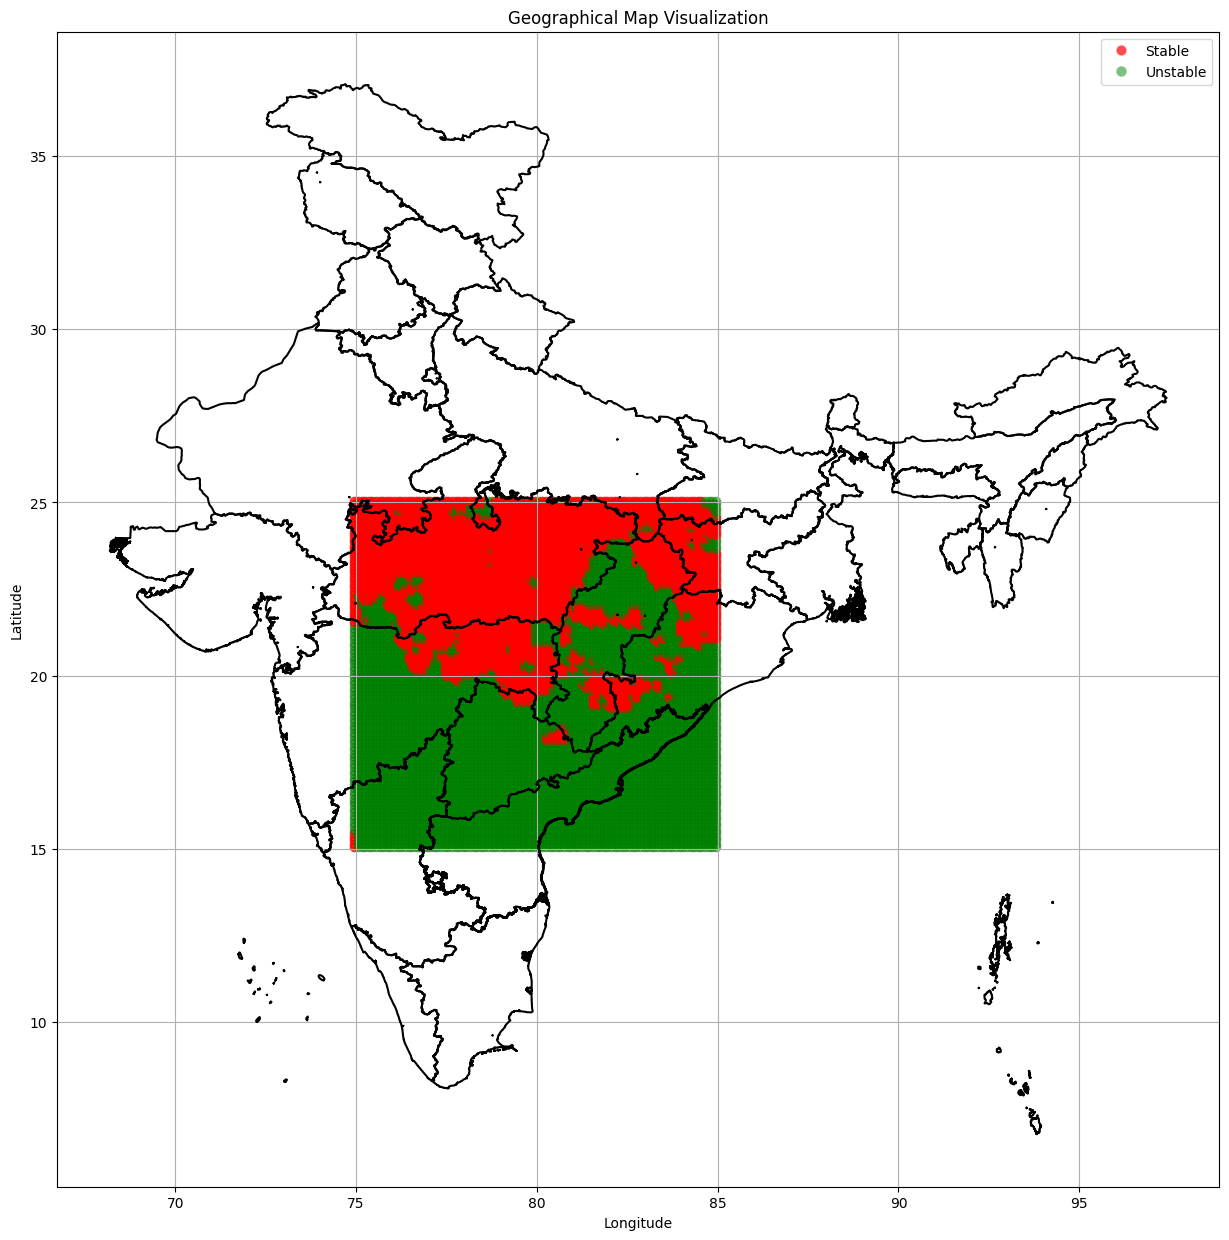

In [91]:
display_geo_map(
    dataframe=central_ind_dataset,
    y_pred=central_ind_y_pred,
    shapefile_path='India_State/india_updated_state_boundary.shp',
    ids=central_ind_dataset['LOC_ID'].values,
    transform=False,
    figsize=(15, 15)
)

## North-East India

In [93]:
ne_ind_dataset = load_dataset(
    dataset_path='ne_india_grid_timeseries.csv',
    bias=1e-2,
    log_transform=True
)

...Loading Dataset...


In [94]:
ne_ind_dataset

,LOC_ID,LONGITUDE,LATITUDE,VALID_POINTS,2015-01-01,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,...,2022-12-22,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31
0,0,87.95,22.05,70090,1.474647,0.388783,1.972385,0.650410,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
1,1,87.95,22.15,70090,1.307837,0.009950,2.059398,0.723403,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
2,2,87.95,22.25,70090,1.209145,0.009950,2.105760,0.789788,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
3,3,87.95,22.35,70090,1.160891,0.009950,2.133840,0.847147,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
4,4,87.95,22.45,70090,1.091025,0.009950,2.183025,0.895440,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8176,8176,97.95,29.65,70090,0.009950,0.009950,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
8177,8177,97.95,29.75,70090,0.009950,0.009950,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
8178,8178,97.95,29.85,70090,0.009950,0.009950,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995
8179,8179,97.95,29.95,70090,0.009950,0.009950,0.009950,0.009950,0.00995,0.00995,...,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995,0.00995


In [95]:
ne_ind_graphs = generate_graphs(
    dataframe=ne_ind_dataset,
    train=False,
    threshold_value=threshold_value
)

...Generating graphs: training_mode: False, threshold_percentile: 25...
...Making year wise dictionary...
...Making cosine similarity dictionary...
...Making mean nodes...
...Making Graphs...
...Generating Labels...


In [96]:
ne_ind_y_pred = make_predictions(
    model=model,
    graphs=ne_ind_graphs
)

...Making predictions...


In [97]:
ne_ind_y_true = get_true_labels(
    model=model,
    graphs=ne_ind_graphs
)

...Getting true labels...


[[ 881 1105]
 [1027 5168]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       0.46      0.44      0.45      1986
      Stable       0.82      0.83      0.83      6195

    accuracy                           0.74      8181
   macro avg       0.64      0.64      0.64      8181
weighted avg       0.74      0.74      0.74      8181



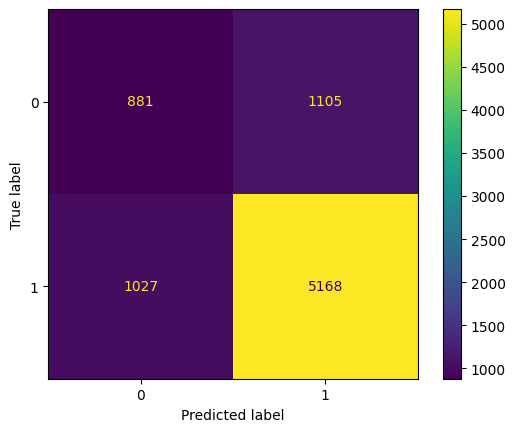

In [98]:
ne_ind_cm = confusion_matrix(list(ne_ind_y_true.values()), list(ne_ind_y_pred.values()))
print(ne_ind_cm)

ConfusionMatrixDisplay(ne_ind_cm).plot()

print('\nClassification Report:')
print(classification_report(list(ne_ind_y_true.values()), list(ne_ind_y_pred.values()), target_names=['Unstable', 'Stable']))

...Plotting geographical map...


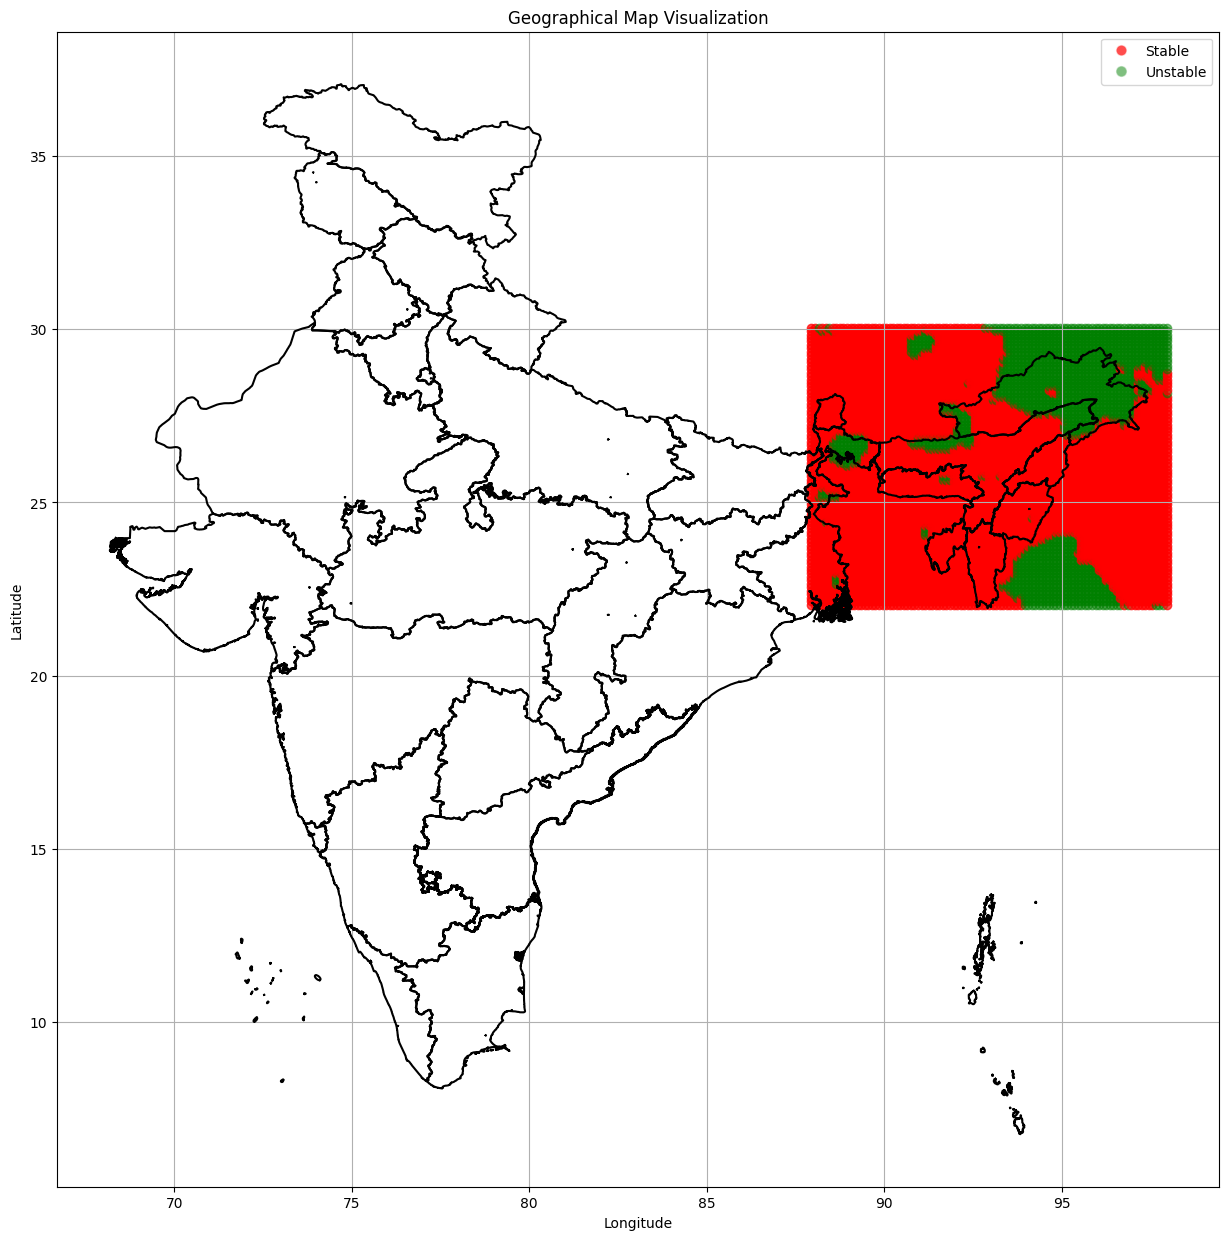

In [99]:
display_geo_map(
    dataframe=ne_ind_dataset,
    y_pred=ne_ind_y_pred,
    shapefile_path='India_State/india_updated_state_boundary.shp',
    ids=ne_ind_dataset['LOC_ID'].values,
    transform=False,
    figsize=(15, 15)
)